In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from nscl.models.embedding.attribute_embedding_space import *
from nscl.datasets.clevr_definition import *
from torch import optim

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# dimensions
input_dim = 64
output_dim = 8
all_shapes = CLEVRDefinition.attribute_concept_map['shape']

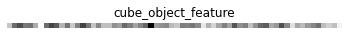

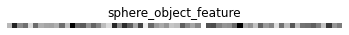

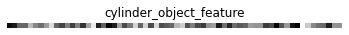

In [3]:
# Generate synthetic features
shape_features = {shape:torch.randn((1,input_dim)) for shape in all_shapes}
for shape, features in shape_features.items():
    plt.figure()
    plt.axis("off")
    plt.title(f'{shape}_object_feature')
    plt.imshow(features, cmap='gray')

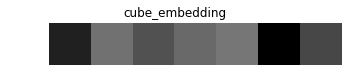

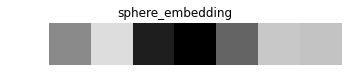

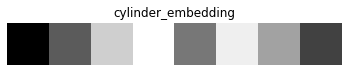

In [4]:
# Convert features to concept embeddings
shape_of = nn.Linear(input_dim, output_dim)
shape_concepts = {shape:shape_of(shape_features[shape]).data for shape in all_shapes}

for shape, concept in shape_concepts.items():
    plt.figure()
    plt.axis("off")
    plt.title(f'{shape}_embedding')
    plt.imshow(concept, cmap='gray')

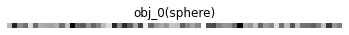

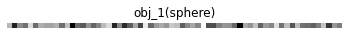

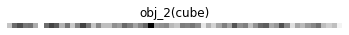

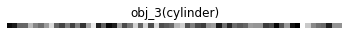

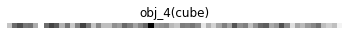

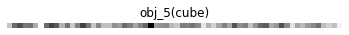

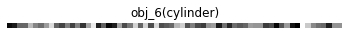

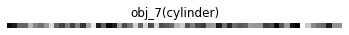

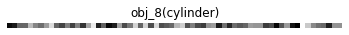

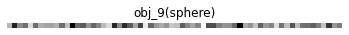

In [7]:
# Generate synthetic dataset
class EmbeddingDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.features)

num_data_per_shape = 100
shape_to_id = {'cube':0, 'sphere':1, 'cylinder':2}
id_to_shape = {0:'cube', 1:'sphere', 2:'cylinder'}

scenes = []
scene_labels = []

for i in range(num_data_per_shape):
    for shape in all_shapes:
        scenes.append(shape_features[shape])
        scene_labels.append(shape_to_id[shape])

dataset = EmbeddingDataset(scenes, scene_labels)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)
for features, shape_ids in dataloader:
    for i in range(len(features)):
        plt.figure()
        plt.axis("off")
        plt.title(f'obj_{i}({id_to_shape[shape_ids[i].item()]})')
        plt.imshow(features[i], cmap='gray')
    break


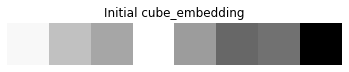

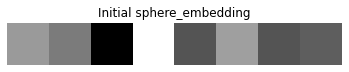

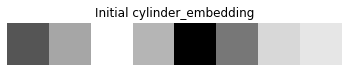

In [8]:
# Generate embedding space
attribute_concept_map = {'shape':['cube', 'sphere', 'cylinder']}
embedding_space = AttributeEmbeddingSpace(attribute_concept_map, input_dim, output_dim)

# print(embedding_space.parameters)
# initial embeddings
for shape in all_shapes:
    plt.figure()
    plt.axis("off")
    plt.title(f'Initial {shape}_embedding')
    plt.imshow(getattr(embedding_space.concept_embeddings, shape).concept_vector.data.unsqueeze(1).t(), cmap='gray')

In [10]:
# Test similarity computation
scene = torch.cat([scenes[0], scenes[1], scenes[2]])
print(embedding_space.similarity(scene, 'cube'))

tensor([3.1705e-05, 2.3360e-01, 7.1056e-01], grad_fn=<SigmoidBackward>)


In [12]:
# Train embedding space
num_epoch = 10
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)
loss_function = nn.MSELoss()
optimiser = optim.Adam(embedding_space.parameters(), lr=0.01)

for i in range(num_epoch):
    for features, shape_ids in dataloader:
        for feature, shape_id in zip(features, shape_ids):
            shape = id_to_shape[shape_id.item()]
            confidence = embedding_space.similarity(feature, shape)
            loss = loss_function(confidence, torch.tensor([1.]))
            loss.backward()
            optimiser.step()


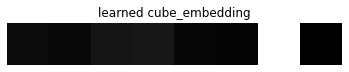

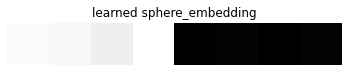

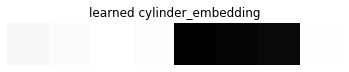

In [13]:
# Learned concept_embeddings
for shape in all_shapes:
    plt.figure()
    plt.axis("off")
    plt.title(f'learned {shape}_embedding')
    plt.imshow(getattr(embedding_space.concept_embeddings, shape).concept_vector.data.unsqueeze(1).t(), cmap='gray')

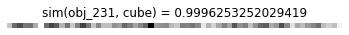

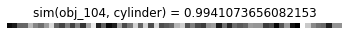

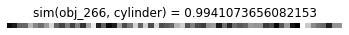

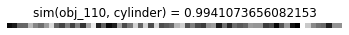

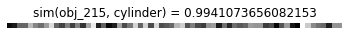

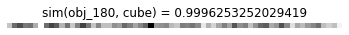

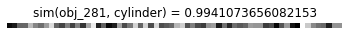

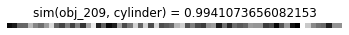

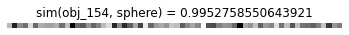

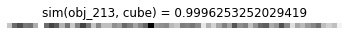

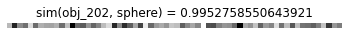

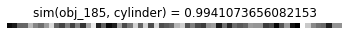

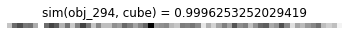

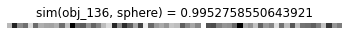

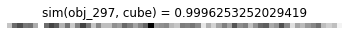

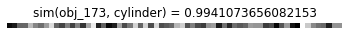

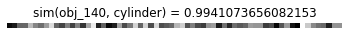

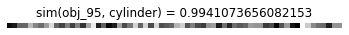

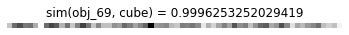

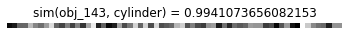

In [14]:
# Check accuracy
for i in np.random.randint(0, len(scenes), 20):
    scene = scenes[i]
    shape = id_to_shape[scene_labels[i]]
    similarity = embedding_space.similarity(scene, shape)
    plt.figure()
    plt.axis("off")
    plt.title(f'sim(obj_{i}, {shape}) = {similarity.item()}')
    plt.imshow(scene, cmap='gray')